In [1]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt
import numpy as np

In [2]:
mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

maxcapacityfor_spp = 90
maxcapacityfor_vspp = 10

radius_spp_wind = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_wind * 3.14)) / 105,5)
radius_vspp_wind = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_wind * 3.14)) / 105,5)

radius_spp_solar = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_solar * 3.14)) / 105,5)
radius_vspp_solar = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_solar * 3.14)) / 105,5)

print('radius_spp_wind km = ',radius_spp_wind*100,' buffer = ',radius_spp_wind)
print('radius_vspp_wind km = ',radius_vspp_wind*100,' buffer = ',radius_vspp_wind)
print('radius_spp_solar km = ',radius_spp_solar*100,' buffer = ',radius_spp_solar)
print('radius_vspp_solar km = ',radius_vspp_solar*100,' buffer = ',radius_vspp_solar)

radius_spp_wind km =  2.404  buffer =  0.02404
radius_vspp_wind km =  0.8009999999999999  buffer =  0.00801
radius_spp_solar km =  1.317  buffer =  0.01317
radius_vspp_solar km =  0.439  buffer =  0.00439


In [3]:
xr_out = xr.open_dataset('Output\\xr_output.nc')
print(xr_out)
print("cap_SPP_wind = ",xr_out['cap_SPP_wind'].sum())
print("cap_VSPP_wind = ",xr_out['cap_VSPP_wind'].sum())
print("cap_SPP_solar = ",xr_out['cap_SPP_solar'].sum())
print("cap_VSPP_solar = ",xr_out['cap_VSPP_solar'].sum())
print(xr_out['ADM1_EN'].where(xr_out['ADM1_EN']=='R0',1,0).count())

<xarray.Dataset>
Dimensions:         (lat: 1069, lon: 597)
Coordinates:
  * lat             (lat) float64 5.621 5.635 5.649 5.663 ... 20.43 20.44 20.45
  * lon             (lon) float64 97.35 97.37 97.38 97.39 ... 105.6 105.6 105.6
Data variables: (12/14)
    SI_Solar        (lat, lon) float64 ...
    SI_Wind         (lat, lon) float64 ...
    AVA_Wind        (lat, lon) float32 ...
    AVA_Solar       (lat, lon) float32 ...
    SI_Wind_max     (lat, lon) float64 ...
    SI_Wind_min     (lat, lon) float64 ...
    ...              ...
    ADM1_EN         (lat, lon) object ...
    region          (lat, lon) object ...
    cap_SPP_wind    (lat, lon) float64 ...
    cap_VSPP_wind   (lat, lon) float64 ...
    cap_SPP_solar   (lat, lon) float64 ...
    cap_VSPP_solar  (lat, lon) float64 ...
cap_SPP_wind =  <xarray.DataArray 'cap_SPP_wind' ()>
array(6357.69026566)
cap_VSPP_wind =  <xarray.DataArray 'cap_VSPP_wind' ()>
array(20454.12046802)
cap_SPP_solar =  <xarray.DataArray 'cap_SPP_solar' ()>

In [4]:
df_wind = xr_out.to_dataframe()
df_wind.reset_index(inplace=True)
df_wind = gpd.GeoDataFrame(df_wind, geometry =gpd.points_from_xy(df_wind['lon'],df_wind['lat']))
df_wind.crs = {'init': 'epsg:4326'}
print(len(df_wind))
for i,c in enumerate(df_wind.columns):
    if c not in (['lon','lat','SI_Wind','SI_Wind_max','SI_Wind_min','region','ADM1_EN','cap_SPP_wind','cap_VSPP_wind','AVA_Wind','geometry']):
        df_wind = df_wind.drop(columns=c)

df_wind_spp = df_wind.drop(columns='cap_VSPP_wind')
df_wind_spp = df_wind_spp.loc[df_wind_spp['cap_SPP_wind'] > 0]
df_wind_spp.reset_index(inplace=True,drop=False)
df_wind_spp.crs = {'init': 'epsg:4326'}
df_wind_spp['buffer'] = df_wind_spp['geometry'].buffer(radius_spp_wind,cap_style = 3)
df_wind_spp = df_wind_spp.set_geometry('buffer')

df_wind_spp['no_spp_wind'] = np.ceil(df_wind_spp['cap_SPP_wind']/maxcapacityfor_spp)
df_wind_spp_normal = df_wind_spp.loc[df_wind_spp['no_spp_wind'] == 1]
df_wind_spp_clustered = df_wind_spp.loc[df_wind_spp['no_spp_wind'] > 1]

df_wind_vspp = df_wind.drop(columns='cap_SPP_wind')
df_wind_vspp = df_wind_vspp.loc[df_wind_vspp['cap_VSPP_wind'] > 0]
df_wind_vspp.reset_index(inplace=True,drop=False)
df_wind_vspp.crs = {'init': 'epsg:4326'}
df_wind_vspp['buffer'] = df_wind_vspp['geometry'].buffer(radius_vspp_wind,cap_style = 3)
df_wind_vspp = df_wind_vspp.set_geometry('buffer')

df_wind_spp.to_csv('Output\\Output_wind_spp.csv',index=False,encoding="utf-8-sig")
df_wind_vspp.to_csv('Output\\Output_wind_vspp.csv',index=False,encoding="utf-8-sig")

print(df_wind_spp)
print(df_wind_vspp)

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


638193


C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Local\Temp\ipykernel_17288\1522938015.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_wind_spp['buffer'] = df_wind_spp['geometry'].buffer(radius_spp_wind,cap_style = 3)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis

      index        lat         lon   SI_Wind  AVA_Wind  SI_Wind_max  \
0     33703   6.398611  101.115278  0.159213      0.27     1.360607   
1     34885   6.426389  100.948611  0.102177      0.18     1.277514   
2     36099   6.454167  101.226389  0.584977      0.99     1.451871   
3     39051   6.523611  100.768056  0.541345      0.99     1.274907   
4     41456   6.579167  101.004167  0.318662      0.54     1.432351   
..      ...        ...         ...       ...       ...          ...   
466  535976  18.079167  103.837500  0.101586      0.18     1.270366   
467  536578  18.093056  103.906944  0.244047      0.45     1.220837   
468  539547  18.162500  103.684722  0.150888      0.27     1.257710   
469  541326  18.204167  103.518056  0.296312      0.54     1.235269   
470  543719  18.259722  103.587500  0.193732      0.36     1.252455   

     SI_Wind_min    ADM1_EN region  cap_SPP_wind                    geometry  \
0            0.0       Yala     R3     14.985000   POINT (101.11528

In [5]:
df_solar = xr_out.to_dataframe()
df_solar.reset_index(inplace=True)
df_solar = gpd.GeoDataFrame(df_solar, geometry =gpd.points_from_xy(df_solar['lon'],df_solar['lat']))
df_solar.crs = {'init': 'epsg:4326'}
print(len(df_solar))
for i,c in enumerate(df_solar.columns):
    if c not in (['lon','lat','SI_Solar','SI_Solar_max','SI_Solar_min','region','ADM1_EN','cap_SPP_solar','cap_VSPP_solar','AVA_Solar','geometry']):
        df_solar = df_solar.drop(columns=c)

df_solar_spp = df_solar.drop(columns='cap_VSPP_solar')
df_solar_spp = df_solar_spp.loc[df_solar_spp['cap_SPP_solar'] > 0]
df_solar_spp.reset_index(inplace=True,drop=False)
df_solar_spp.crs = {'init': 'epsg:4326'}
df_solar_spp['buffer'] = df_solar_spp['geometry'].buffer(radius_spp_solar,cap_style = 3)
df_solar_spp = df_solar_spp.set_geometry('buffer')

df_solar_vspp = df_solar.drop(columns='cap_SPP_solar')
df_solar_vspp = df_solar_vspp.loc[df_solar_vspp['cap_VSPP_solar'] > 0]
df_solar_vspp.reset_index(inplace=True,drop=False)
df_solar_vspp.crs = {'init': 'epsg:4326'}
df_solar_vspp['buffer'] = df_solar_vspp['geometry'].buffer(radius_vspp_solar,cap_style = 3)
df_solar_vspp = df_solar_vspp.set_geometry('buffer')


df_solar_spp.to_csv('Output\\Output_solar_spp.csv',index=False,encoding="utf-8-sig")
df_solar_vspp.to_csv('Output\\Output_solar_vspp.csv',index=False,encoding="utf-8-sig")

print(df_solar_spp)
print(df_solar_vspp)

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


638193


C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Local\Temp\ipykernel_17288\507924514.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_solar_spp['buffer'] = df_solar_spp['geometry'].buffer(radius_spp_solar,cap_style = 3)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of ax

      index        lat         lon  SI_Solar  AVA_Solar  SI_Solar_max  \
0     13461   5.926389  101.893056  0.421140       0.45      2.106166   
1     15250   5.968056  101.865278  0.353046       0.36      2.310451   
2     17040   6.009722  101.851389  0.173553       0.18      2.441434   
3     18834   6.051389  101.893056  0.774929       0.72      2.535497   
4     21221   6.106944  101.879167  0.237292       0.27      1.978207   
..      ...        ...         ...       ...        ...           ...   
773  554815  18.523611  100.156944  0.139054       0.18      1.738180   
774  557244  18.579167  100.726389  0.584203       0.63      2.273361   
775  560232  18.648611  100.768056  0.325974       0.36      2.124134   
776  562022  18.690278  100.754167  0.211886       0.27      1.849661   
777  563814  18.731944  100.768056  0.325405       0.36      2.271182   

     SI_Solar_min     ADM1_EN region  cap_SPP_solar  \
0             0.0  Narathiwat     R3      18.900000   
1            

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


total wind capacity =  26811.810733678518
total SPP wind capacity =  6357.6902656562
total VSPP wind capacity =  20454.12046802232


<Axes: >

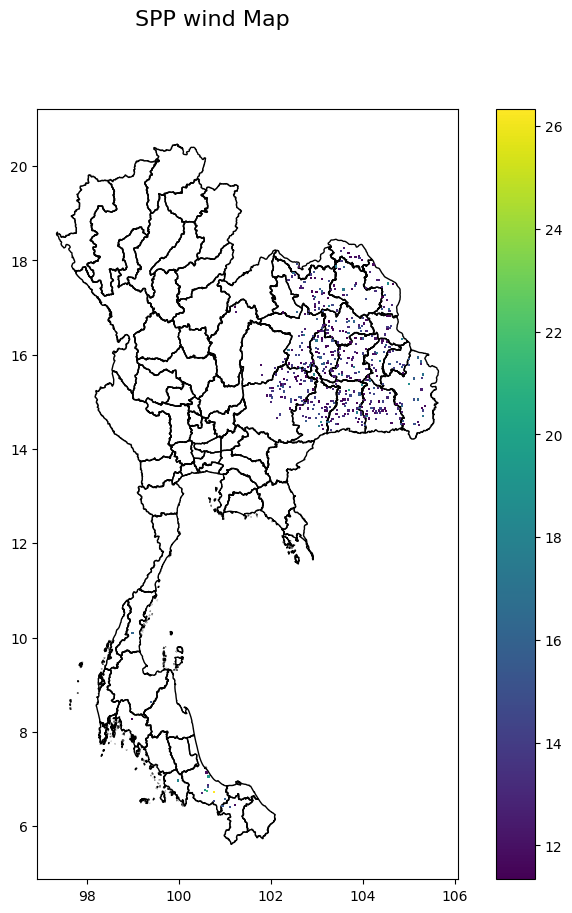

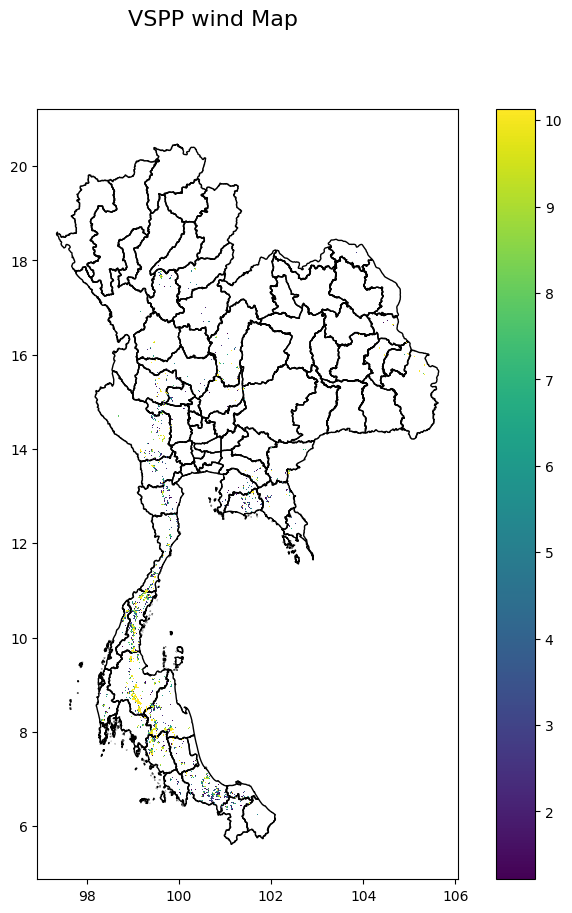

In [6]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

print("total wind capacity = ", df_wind_spp['cap_SPP_wind'].sum() + df_wind_vspp['cap_VSPP_wind'].sum())
print("total SPP wind capacity = ", df_wind_spp['cap_SPP_wind'].sum())
print("total VSPP wind capacity = ", df_wind_vspp['cap_VSPP_wind'].sum())

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('SPP wind Map', fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
df_wind_spp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_SPP_wind')

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('VSPP wind Map', fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
df_wind_vspp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_VSPP_wind')


total solar capacity =  950429.728779542
total SPP solar capacity =  18846.0006818744
total VSPP solar capacity =  931583.7280976676


<Axes: >

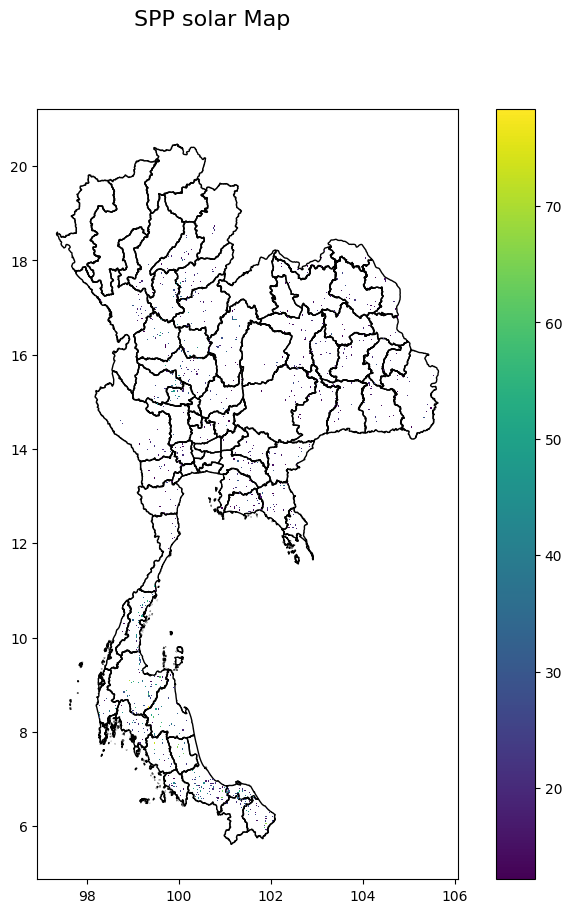

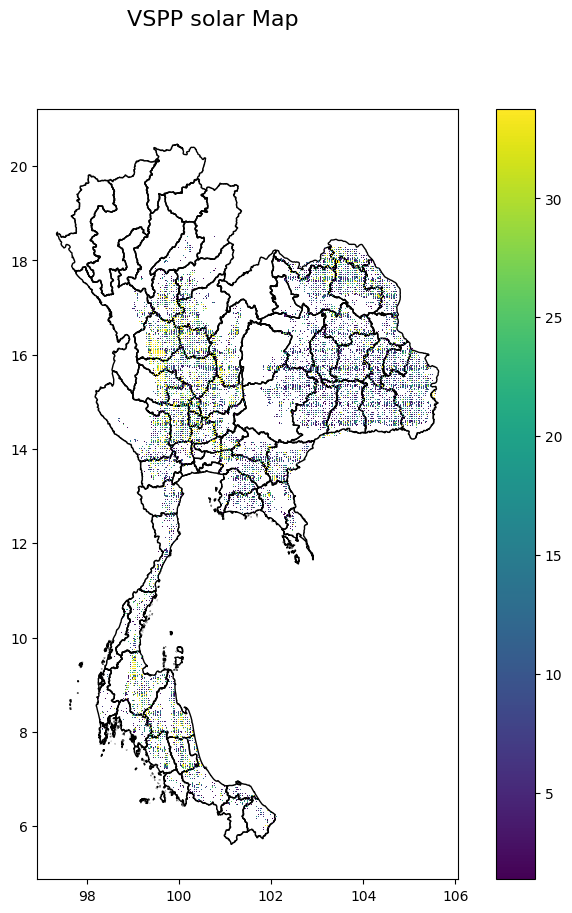

In [7]:
print("total solar capacity = ", df_solar_spp['cap_SPP_solar'].sum() + df_solar_vspp['cap_VSPP_solar'].sum())
print("total SPP solar capacity = ", df_solar_spp['cap_SPP_solar'].sum())
print("total VSPP solar capacity = ", df_solar_vspp['cap_VSPP_solar'].sum())

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('SPP solar Map', fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
df_solar_spp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_SPP_solar')

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('VSPP solar Map', fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
df_solar_vspp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_VSPP_solar')

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


total wind capacity =  468.99001765265
total SPP wind capacity =  455.22001743330003
total VSPP wind capacity =  13.770000219349999
total solar capacity =  17219.250597472463
total SPP solar capacity =  164.7000074386
total VSPP solar capacity =  17054.55059003386


C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


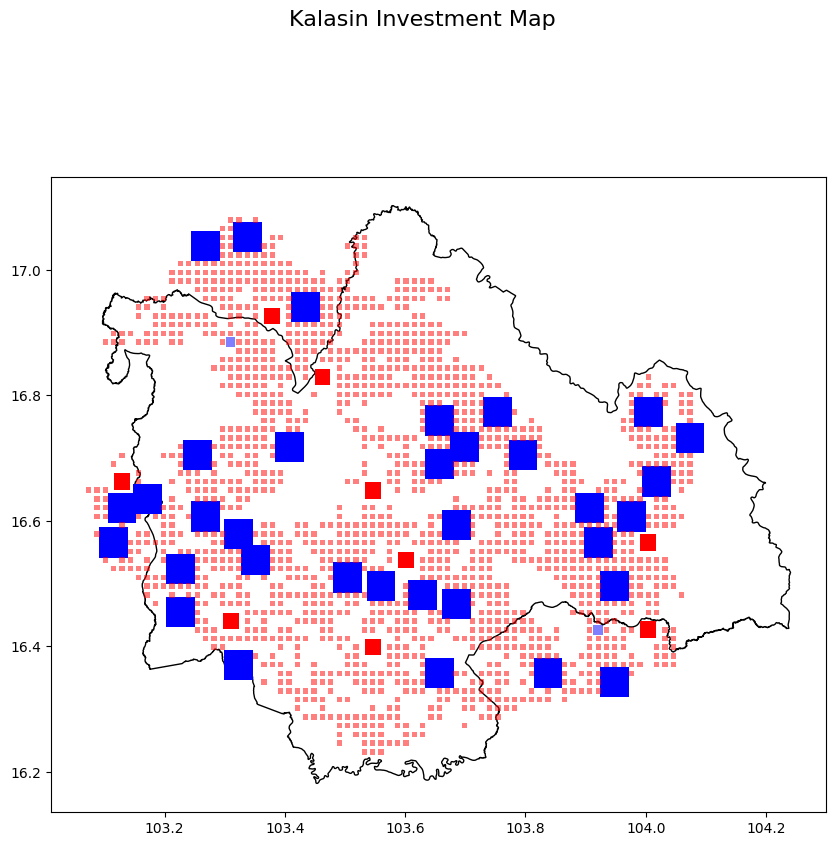

In [8]:
province = 'Kalasin'
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
specificarea = thailandmap.loc[thailandmap['ADM1_EN'] == province]
bound = specificarea.unary_union.bounds

print("total wind capacity = ", df_wind_spp['cap_SPP_wind'].loc[df_wind_spp['ADM1_EN'] == province].sum() + df_wind_vspp['cap_VSPP_wind'].loc[df_wind_vspp['ADM1_EN'] == province].sum())
print("total SPP wind capacity = ", df_wind_spp['cap_SPP_wind'].loc[df_wind_spp['ADM1_EN'] == province].sum())
print("total VSPP wind capacity = ", df_wind_vspp['cap_VSPP_wind'].loc[df_wind_vspp['ADM1_EN'] == province].sum())

print("total solar capacity = ", df_solar_spp['cap_SPP_solar'].loc[df_solar_spp['ADM1_EN'] == province].sum() + df_solar_vspp['cap_VSPP_solar'].loc[df_solar_vspp['ADM1_EN'] == province].sum())
print("total SPP solar capacity = ", df_solar_spp['cap_SPP_solar'].loc[df_solar_spp['ADM1_EN'] == province].sum())
print("total VSPP solar capacity = ", df_solar_vspp['cap_VSPP_solar'].loc[df_solar_vspp['ADM1_EN'] == province].sum())

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(province + ' Investment Map ', fontsize=16)
specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
try:
    df_wind_spp.loc[df_wind_spp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 1,column = 'cap_SPP_wind',color = 'blue')
    df_wind_vspp.loc[df_wind_vspp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 2,column = 'cap_VSPP_wind',color = 'blue',alpha = 0.5)
except:
    None
try:
    df_solar_spp.loc[df_solar_spp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 3,column = 'cap_SPP_solar',color = 'red')
    df_solar_vspp.loc[df_solar_vspp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 4,column = 'cap_VSPP_solar',color = 'red',alpha = 0.5)
except:
    None